# Decision Tree

## Imports

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, recall_score, f1_score, roc_auc_score,roc_curve, accuracy_score, precision_score,classification_report
from sklearn.ensemble import RandomForestClassifier
df = pd.read_csv('cleaned_data.csv')
# df = df.drop(['Income'], axis=1)


## Find optimal model using GridSerachCV

In [9]:
def find_optimal_model(X_train, y_train):
    dtree = DecisionTreeClassifier()
    parameters = {'max_depth':[2,3,4,5,6,7,8,9], 
                  'min_samples_split':[3,5,7,9,11,13,15,17,19],
                  'min_samples_leaf':[5,7,9,11,13,15,17,19,21]}
    grid_dtree = GridSearchCV(dtree, param_grid=parameters, cv=10, refit=True)
    grid_dtree.fit(X_train, y_train)
    print('GridSearchCV optimal parameter:', grid_dtree.best_params_)
    return grid_dtree.best_estimator_

## Evaluate

In [10]:
# It returns Confution Matrix, Precision, Recall, F1, Accuracy
def model_evaluate(y_test, prediction):
    # get confusion matrix
    confusion = confusion_matrix( y_test, prediction, normalize='true')
    # get accuracy score
    accuracy = accuracy_score(y_test , prediction)
    # get precision
    precision = precision_score(y_test , prediction)
    # get recall
    recall = recall_score(y_test , prediction)
    # get f1 score
    f1 = f1_score(y_test,prediction)
    result = {
        "precision": [precision.round(4)],
        "recall": [recall.round(4)],
        "f1": [f1.round(4)],
        "accuracy": [accuracy.round(4)],
    }
    return (confusion, pd.DataFrame(result))

def plot_confusion_matrix(ax, confusion):    
    sns.heatmap(confusion, annot=True, cbar=False, ax=ax)

def plot_roc_curve(fig, fpr, tpr, auc, title):
    fig.plot(fpr, tpr, 'o-', ms=1, label="{} auc={}".format(title, auc.round(4)))     
    fig.plot([0, 1], [0, 1], 'k--')
    fig.legend(loc=4)
    





## Defalut Decision Tree VS Optimal Decision Tree

Split train dataset and test dataset      
X_train:(72, 9)
X_test:(48, 9)
y_train:(72,)
y_test:(48,)

GridSearchCV optimal parameter: {'max_depth': 2, 'min_samples_leaf': 9, 'min_samples_split': 3}

Defalut Decision Tree Result
   precision  recall   f1  accuracy
0     0.9474  0.8571  0.9    0.9167

Optimal Decision Tree Result
   precision  recall      f1  accuracy
0     0.9545     1.0  0.9767    0.9792


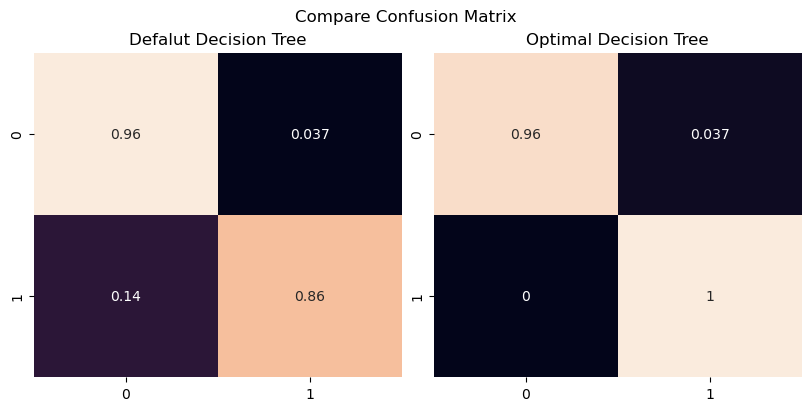

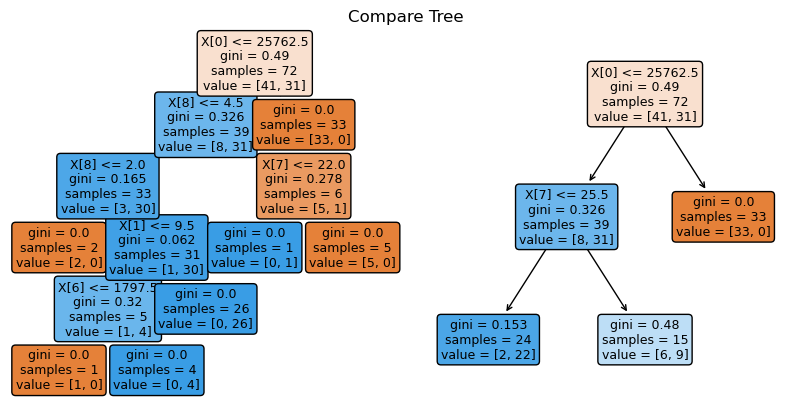

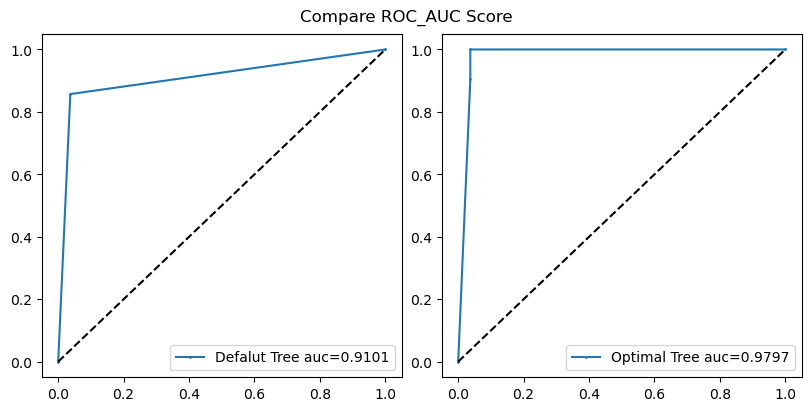

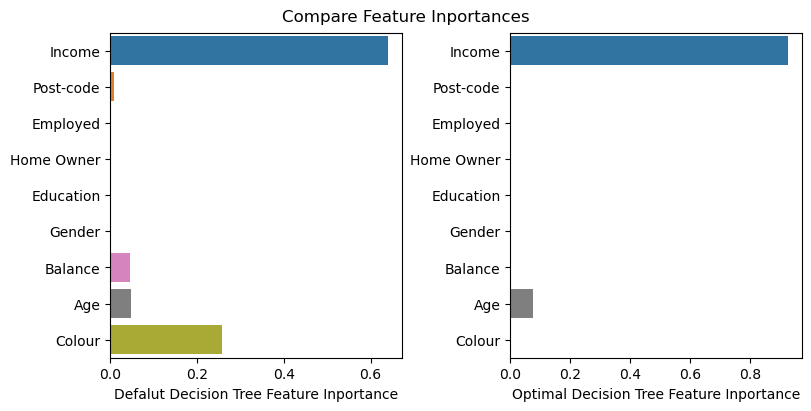

In [11]:
X_features = df.drop(['Fraud'], axis=1)
y_targets = df['Fraud']
X_train, X_test, y_train, y_test=train_test_split(X_features, y_targets, test_size=0.4, random_state=1)
print("Split train dataset and test dataset\
      \nX_train:{}\nX_test:{}\ny_train:{}\ny_test:{}\n".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

defalut_tree = DecisionTreeClassifier().fit(X_train, y_train)
dt_pred = defalut_tree.predict(X_test)
dt_evaluation = model_evaluate(y_test, dt_pred)

optimal_tree = find_optimal_model(X_train, y_train)
op_pred = optimal_tree.predict(X_test)
op_evaluation = model_evaluate(y_test, op_pred)

print("\nDefalut Decision Tree Result\n{}".format(dt_evaluation[1]))
print("\nOptimal Decision Tree Result\n{}".format(op_evaluation[1]))


fig, axs = plt.subplots(figsize=(8, 4), ncols=2, constrained_layout=True )
fig.suptitle("Compare Confusion Matrix", fontsize=12)
axs[0].title.set_text("Defalut Decision Tree")
axs[1].title.set_text("Optimal Decision Tree")
plot_confusion_matrix(ax=axs[0], confusion=dt_evaluation[0])
plot_confusion_matrix(ax=axs[1], confusion=op_evaluation[0])

fig, ax = plt.subplots(figsize=(8, 4), ncols=2, constrained_layout=True )
fig.suptitle("Compare Tree", fontsize=12)
plot_tree(defalut_tree, fontsize=9, filled=True,rounded=True, ax=ax[0])
plot_tree(optimal_tree, fontsize=9, filled=True,rounded=True, ax=ax[1])
plt.show()


df_tree_pred_proba = defalut_tree.predict_proba(X_test)[:,1]
df_roc_auc = roc_auc_score(y_test, df_tree_pred_proba)
df_fpr, df_tpr, _ = roc_curve(y_test, df_tree_pred_proba)

op_tree_pred_proba = optimal_tree.predict_proba(X_test)[:,1]
op_roc_auc = roc_auc_score(y_test, op_tree_pred_proba)
op_fpr, op_tpr, _ = roc_curve(y_test, op_tree_pred_proba)

fig, ax = plt.subplots(figsize=(8, 4), ncols=2, constrained_layout=True )
fig.suptitle("Compare ROC_AUC Score", fontsize=12)
plot_roc_curve(ax[0], df_fpr, df_tpr, df_roc_auc, "Defalut Tree")
plot_roc_curve(ax[1], op_fpr, op_tpr, op_roc_auc, "Optimal Tree")
plt.show()

fig, ax = plt.subplots(figsize=(8, 4), ncols=2, constrained_layout=True )
fig.suptitle("Compare Feature Inportances", fontsize=12)
df_tree_feature_importances = pd.DataFrame(defalut_tree.feature_importances_, index=X_features.columns, columns=["Defalut Decision Tree Feature Inportance"])
# print(df_tree_feature_importances)
sns.barplot(x="Defalut Decision Tree Feature Inportance", y=X_features.columns, data=df_tree_feature_importances, ax=ax[0])

op_tree_feature_importances = pd.DataFrame(optimal_tree.feature_importances_, index=X_features.columns, columns=["Optimal Decision Tree Feature Inportance"])
# print(op_tree_feature_importances)
sns.barplot(x="Optimal Decision Tree Feature Inportance", y=X_features.columns, data=op_tree_feature_importances, ax=ax[1])
plt.show()

# Random Forest

In [12]:
def find_optimal_random_forest(X_train, y_train):
    params = { 'n_estimators' : [50,100,150],
           'max_depth' : [3, 5, 7],
           'min_samples_leaf' : [4, 8, 12, 16],
           'min_samples_split' : [4, 8, 12, 16]
            }
    rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
    grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 10, n_jobs = -1)
    grid_cv.fit(X_train, y_train)
    print('GridSearchCV optimal parameter: ', grid_cv.best_params_)
    return grid_cv.best_estimator_


GridSearchCV optimal parameter:  {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 50}

Optimal Random Forest Result
   precision  recall      f1  accuracy
0     0.9545     1.0  0.9767    0.9792


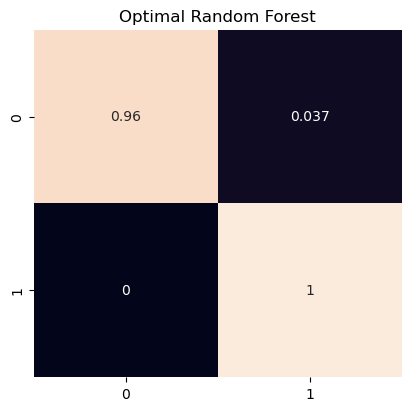

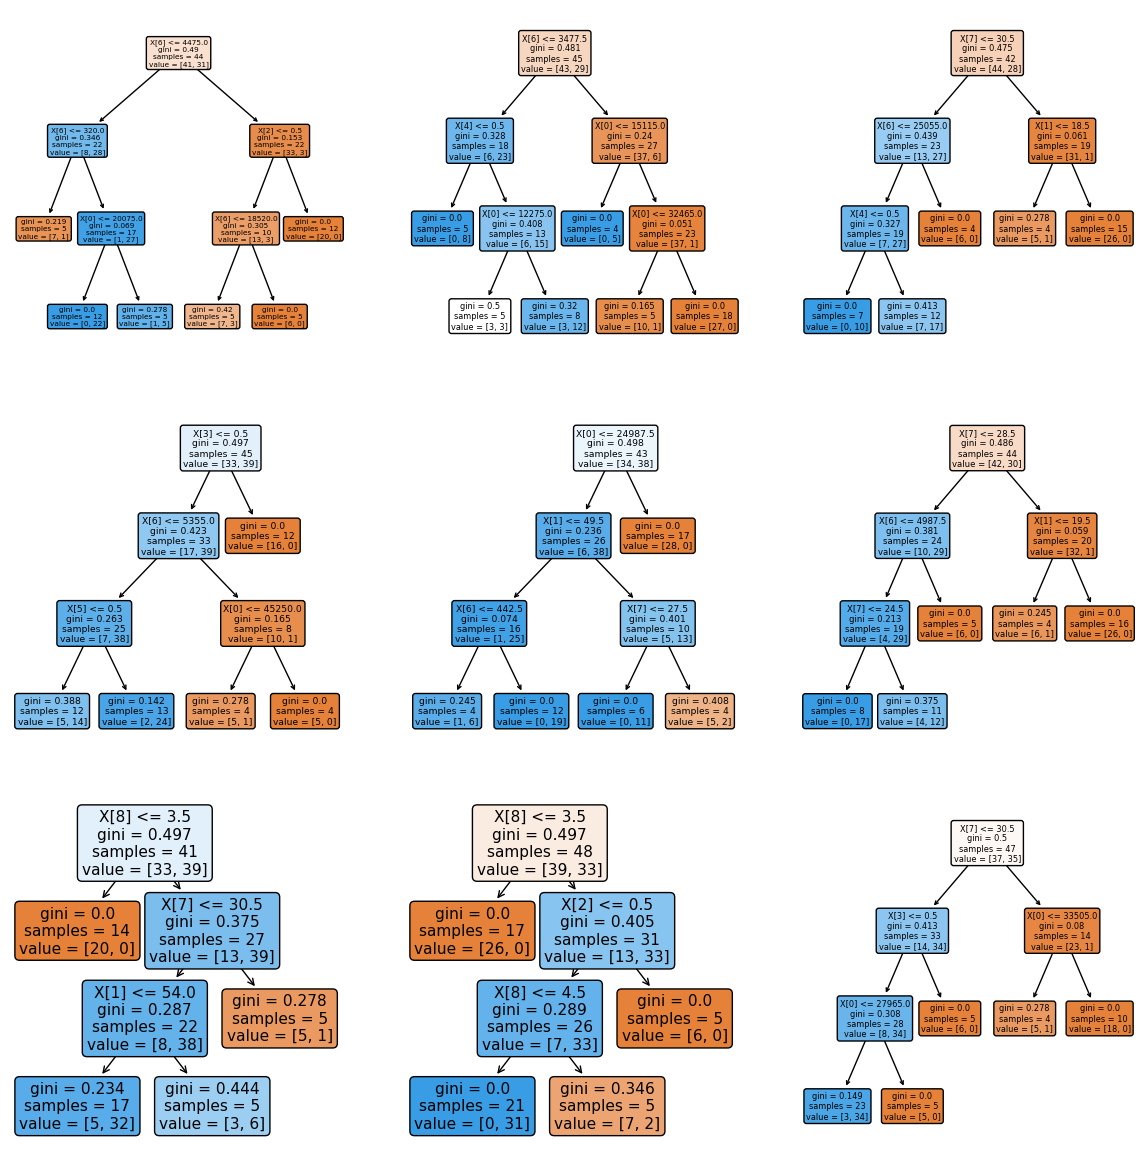

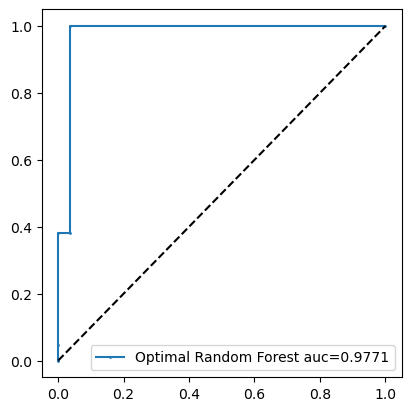

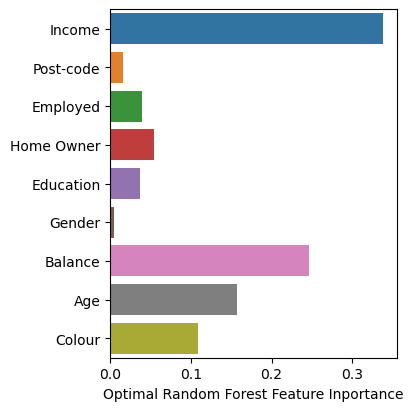

In [13]:
X_features = df.drop(['Fraud'], axis=1)
y_targets = df['Fraud']
X_train, X_test, y_train, y_test=train_test_split(X_features, y_targets, test_size=0.4, random_state=1)

optimal_random_forest = find_optimal_random_forest(X_train, y_train)
optimal_random_forest_predicts = optimal_random_forest.predict(X_test)
optimal_random_forest_evaluation = model_evaluate(y_test, optimal_random_forest_predicts)

print("\nOptimal Random Forest Result\n{}".format(optimal_random_forest_evaluation[1]))

fig, axs = plt.subplots(figsize=(4, 4), constrained_layout=True )
axs.title.set_text("Optimal Random Forest")
plot_confusion_matrix(ax=axs, confusion=optimal_random_forest_evaluation[0])

fig, ax = plt.subplots(figsize=(12, 12), nrows=3, ncols=3)
fig.tight_layout()
for i, model in enumerate(optimal_random_forest.estimators_):
    if i > 8:break
    row = int(i/3)
    col = i%3
    plot_tree(optimal_random_forest.estimators_[i], filled=True, impurity=True,rounded=True, ax=ax[row][col])
plt.show()

optimal_random_forest_pred_proba = optimal_random_forest.predict_proba(X_test)[:,1]
op_rf_roc_auc = roc_auc_score(y_test, optimal_random_forest_pred_proba)
op_rf_fpr, op_rf_tpr, _ = roc_curve(y_test, optimal_random_forest_pred_proba)

fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True )
plot_roc_curve(ax, op_rf_fpr, op_rf_tpr, op_rf_roc_auc, "Optimal Random Forest")
plt.show()

fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True )
op_random_forest_feature_importances = pd.DataFrame(optimal_random_forest.feature_importances_, index=X_features.columns, columns=["Optimal Random Forest Feature Inportance"])
# print(op_random_forest_feature_importances)
sns.barplot(x="Optimal Random Forest Feature Inportance", y=X_train.columns, data=op_random_forest_feature_importances, ax=ax)
plt.show()